In [450]:
import pandas as pd
import nltk
import gzip
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import random 
from pylab import rcParams

rcParams['figure.figsize'] = 15, 10
np.random.seed(42)

## Introduction



## Table of Contents

<p>
<div class="lev1"><a href="#Data-Overview"><span class="toc-item-num">1.&nbsp;&nbsp;</span>Data Overview</a></div>
<div class="lev1"><a href="#Characteristic-Exctraction"><span class="toc-item-num">2.&nbsp;&nbsp;</span>Characteristic exctraction</a></div>
<div class="lev1"><a href="#Sentiment-Learning"><span class="toc-item-num">3.&nbsp;&nbsp;</span>Sentiment Learning</a></div>
<div class="lev1"><a href="#Application-to-the-products"><span class="toc-item-num">4.&nbsp;&nbsp;</span>Application to the products</a></div>

# Data Overview

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

def readSerialized(path):
    return pd.read_pickle(path)

In [3]:
df_elec = readSerialized('serialized_electronics')

In [4]:
df_meta = readSerialized('metadata_electronics_serialized')

### Formats

In [5]:
df_elec['reviewTime']  = pd.to_datetime(df_elec['reviewTime'],format='%m %d, %Y')
df_elec.dtypes

summary                   object
reviewerName              object
reviewTime        datetime64[ns]
overall                  float64
asin                      object
helpful                   object
unixReviewTime             int64
reviewerID                object
reviewText                object
dtype: object

In [6]:
df_meta = df_meta[pd.notnull(df_meta['brand'])]
df_meta.dtypes

title           object
description     object
imUrl           object
categories      object
asin            object
price          float64
salesRank       object
related         object
brand           object
dtype: object

### Missing values

In [256]:
df_merged = df_meta.merge(df_elec, left_on='asin', right_on='asin', how='inner')
df_merged['reviewLength'] = df_merged['reviewText'].str.len()

df_plot = df_merged.copy()
df_plot = df_plot[pd.notnull(df_plot['price'])]
df_plot = df_plot[pd.notnull(df_plot['reviewLength'])]

### Distributions

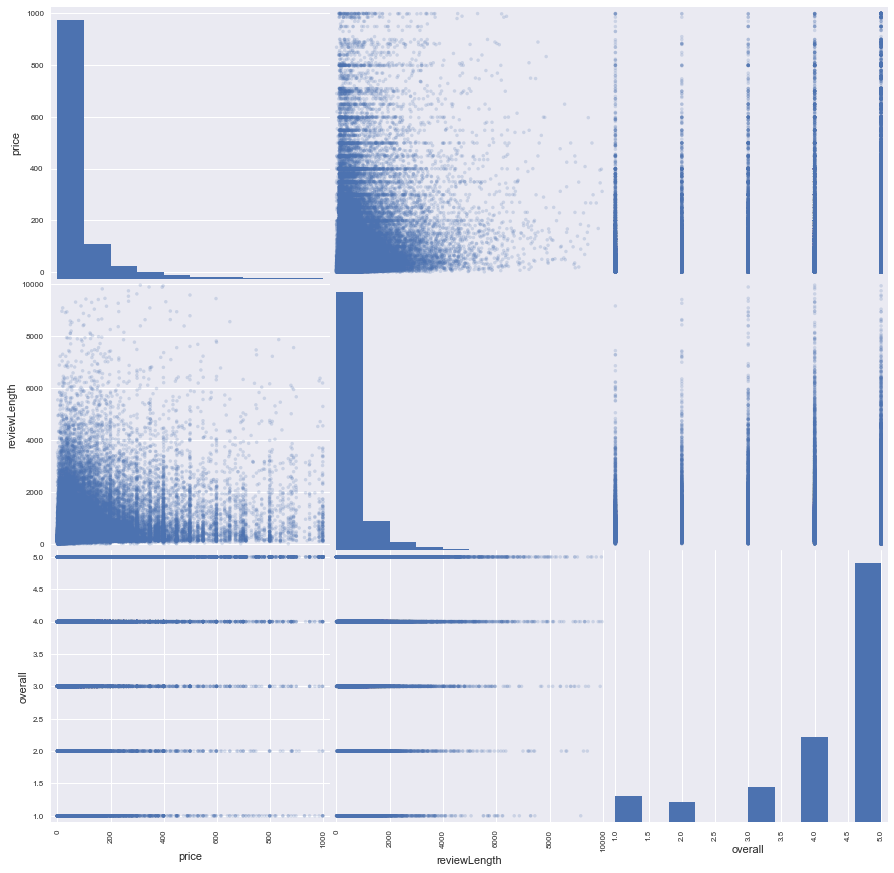

In [250]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_plot[['price','reviewLength','overall']].sample(100000,random_state = 0), alpha=0.2, figsize=(15, 15), diagonal='hist')
plt.show()

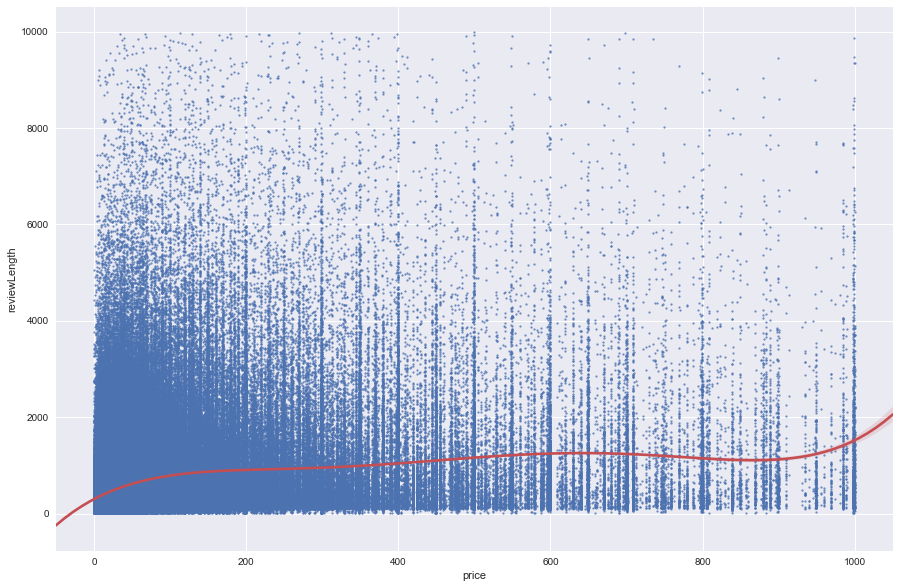

In [77]:
sns.regplot(y='reviewLength', x='price', data=df_plot,scatter_kws={'s':5},line_kws={'color':'r'},order=5)
plt.show()

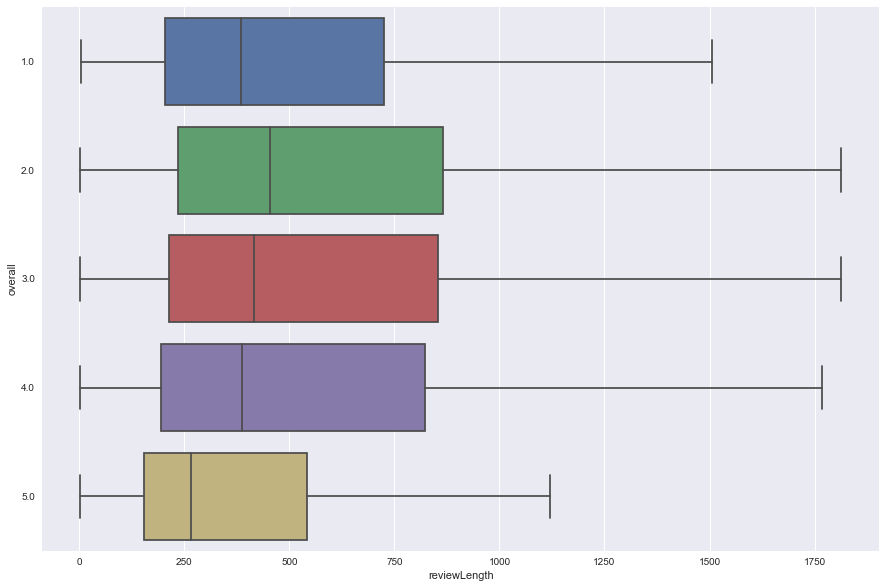

In [252]:
sns.boxplot(y='overall', x='reviewLength', data=df_plot, orient='h', showfliers=False)
plt.show()

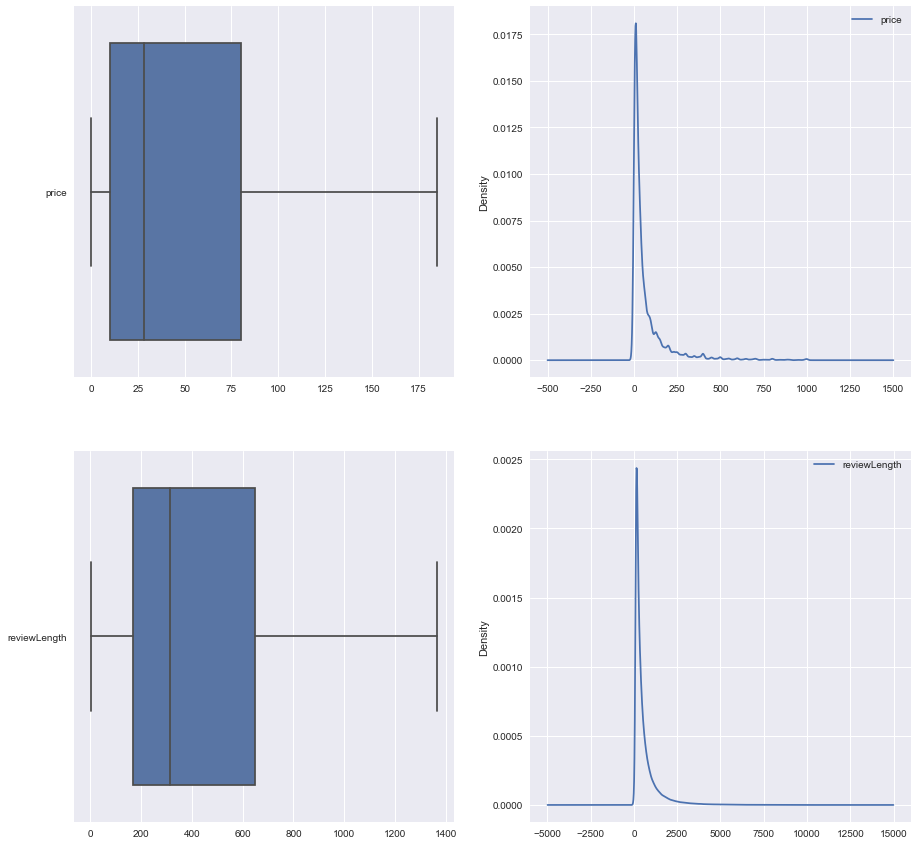

In [253]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.boxplot(data= df_plot[['price']],orient='h', showfliers=False,ax=axes[0,0])
df_plot[['price']].plot.kde(ax=axes[0,1])
sns.boxplot(data= df_plot[['reviewLength']],orient='h', showfliers=False,ax=axes[1,0])
df_plot[['reviewLength']].plot.kde(ax=axes[1,1])

plt.show()

price    73.538928
dtype: float64


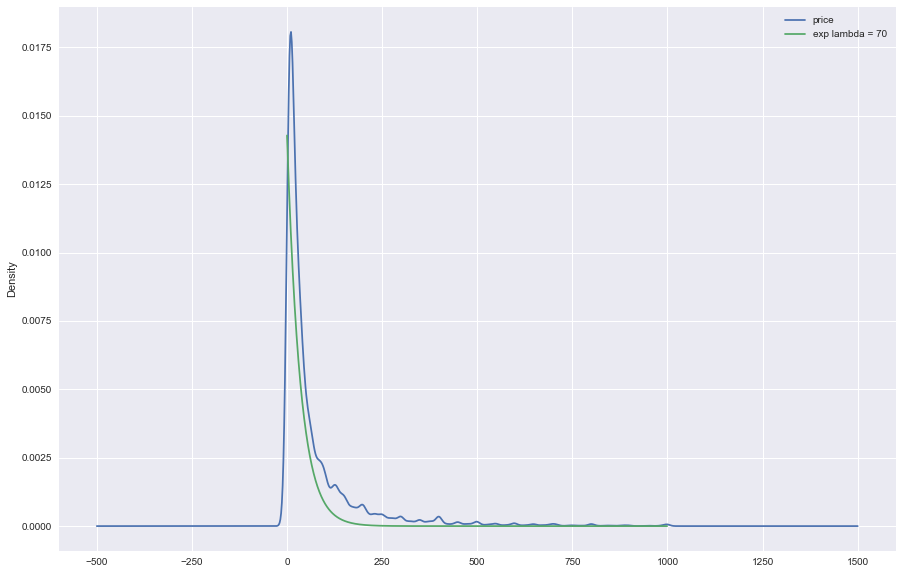

In [558]:
import scipy
import scipy.stats

d = df_plot[['price']]
ax = d.plot.kde()
x = ax.get_children()[0]._x
y = ax.get_children()[0]._y

print(d.mean())

scale = 70
loc = -500

pdf_fitted = scipy.stats.expon.pdf(x - loc, scale=scale)
plt.plot(pdf_fitted,label= ('exp lambda = ' + str(scale)))
plt.legend(loc='best')
plt.show()

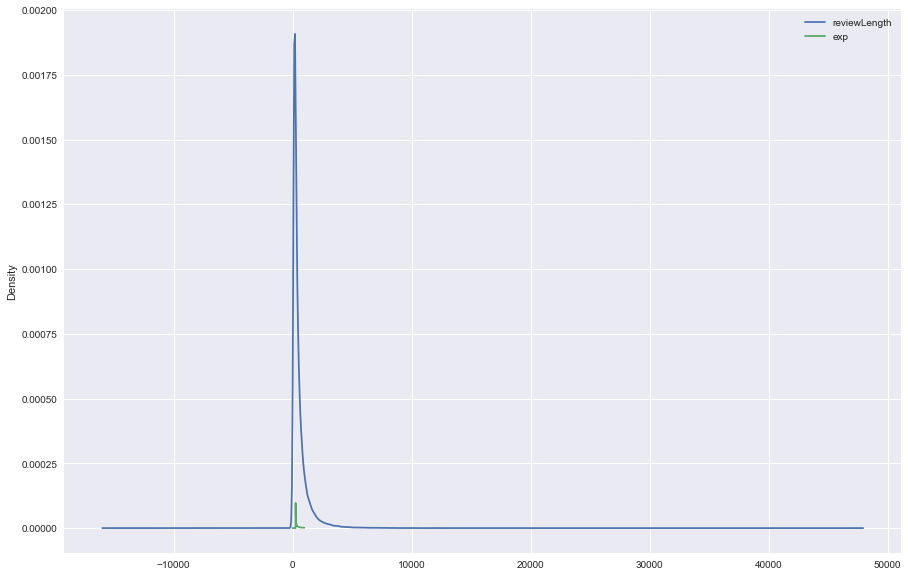

In [572]:
import scipy
import scipy.stats

d = df_plot[['reviewLength']].sample(100000)
ax = d.plot.kde()

x = ax.get_children()[0]._x
y = ax.get_children()[0]._y

scale = 1000
loc = -500

pdf_fitted = scipy.stats.pareto.pdf(x,loc=loc,b = 2, scale=scale)
plt.plot(pdf_fitted,label= 'exp')
plt.legend(loc='best')
plt.show()

### Correlations

In [114]:
df_merged[['price','reviewLength','overall']].corr()

,price,reviewLength,overall
price,1.000000,0.249120,0.025969
reviewLength,0.249120,1.000000,-0.076393
overall,0.025969,-0.076393,1.000000


# Characteristic Exctraction

In [143]:
def filterTags(w1,w2):
    return (nltk.pos_tag(nltk.word_tokenize(w1))[0][1] == 'JJ' and nltk.pos_tag(nltk.word_tokenize(w2))[0][1] == 'NN') or \
     (nltk.pos_tag(nltk.word_tokenize(w1))[0][1] == 'RB' and nltk.pos_tag(nltk.word_tokenize(w2))[0][1] == 'VBN')

def getBest(text):
    ignored_words = nltk.corpus.stopwords.words('english')
    word_filter = lambda w: len(w) < 3 or w.lower() in ignored_words
    
    tokens = nltk.word_tokenize(text)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    
    finder = nltk.BigramCollocationFinder.from_words(tokens)
    finder.apply_word_filter(word_filter)    
    finder.apply_freq_filter(1)
    res = finder.ngram_fd.most_common(1)
        
    res = [x for x in res if filterTags(x[0][0],x[0][1])]

    if(len(res) > 0):
        return res
    else:
        return np.nan

In [144]:
from timeit import default_timer as timer

df_product = df_elec.groupby(["asin"])['reviewText'].agg(lambda x:''.join(set(x))).reset_index()
df_product = df_product.sample(n=10000)

start = timer()
df_product["reviewText"] = df_product["reviewText"].apply(lambda x: getBest(x))
end = timer()
print(end - start)  

773.1181047955715


In [412]:
df_product = df_product.dropna(how = 'any')
df_product

,asin,reviewText
44112,B005WXI31S,"[((original, Canon), 3)]"
51510,B008L5TQIS,"[((hard, drive), 3)]"
27709,B0036ZE6SS,"[((hard, drive), 8)]"
54011,B009K6GQEY,"[((hard, drive), 3)]"
5722,B0007KQWD2,"[((optical, viewfinder), 5)]"
322,B00004SUG7,"[((good, sound), 3)]"
50760,B008BVKVGS,"[((original, battery), 2)]"
59565,B00DH101WQ,"[((high, quality), 7)]"
23645,B002I9S9PE,"[((low, light), 8)]"
26705,B0031U1J1K,"[((hard, drive), 3)]"


# Sentiment Learning

In [451]:
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.sentiment.util import mark_negation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.base import TransformerMixin

df_ML = df_elec[(df_elec["reviewText"].str.len()<100)].copy()
df_ML['score'] = df_elec["overall"].apply(lambda x : -1 if x < 3 else 1)
df_ML["reviewText"] = df_ML["reviewText"].apply(lambda x: x.lower())

df_0 = (df_ML[df_ML["score"] == -1])
df_1 = (df_ML[df_ML["score"] == 1])

if df_0.shape[0] > df_1.shape[0]:
    df_0 = df_0.sample(df_1.shape[0])
else:
    df_1 = df_1.sample(df_0.shape[0])
    
sentiment_data = pd.concat([df_0, df_1])
X = sentiment_data["reviewText"]
y = sentiment_data["score"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)


print(X_train.shape)
print(X_test.shape)

(5450,)
(606,)


In [452]:
bigram_clf = Pipeline([
('vectorizer', CountVectorizer(analyzer="word",
ngram_range=(1, 2),
tokenizer=word_tokenize, 
# tokenizer=lambda text: mark_negation(word_tokenize(text)),
preprocessor=lambda text: text.replace("<br />", " "),)),
('classifier', MLPClassifier(verbose = True))
])
bigram_clf.fit(X_train, y_train)
bigram_clf.score(X_test, y_test)

Iteration 1, loss = 0.52847880
Iteration 2, loss = 0.21626307
Iteration 3, loss = 0.11786590
Iteration 4, loss = 0.07878322
Iteration 5, loss = 0.06126277
Iteration 6, loss = 0.05163929
Iteration 7, loss = 0.04578108
Iteration 8, loss = 0.04186051
Iteration 9, loss = 0.03893974
Iteration 10, loss = 0.03687979
Iteration 11, loss = 0.03524581
Iteration 12, loss = 0.03401061
Iteration 13, loss = 0.03308315
Iteration 14, loss = 0.03212393
Iteration 15, loss = 0.03142843
Iteration 16, loss = 0.03088604
Iteration 17, loss = 0.03034287
Iteration 18, loss = 0.02993281
Iteration 19, loss = 0.02958224
Iteration 20, loss = 0.02934733
Iteration 21, loss = 0.02905120
Iteration 22, loss = 0.02876829
Iteration 23, loss = 0.02870583
Iteration 24, loss = 0.02841047
Iteration 25, loss = 0.02827292
Iteration 26, loss = 0.02810219
Iteration 27, loss = 0.02805864
Iteration 28, loss = 0.02800708
Iteration 29, loss = 0.02779343
Iteration 30, loss = 0.02770849
Iteration 31, loss = 0.02781355
Iteration 32, los

0.87128712871287128

In [453]:
X = ["low price","expensive","cheap","high quality","low quality","well made",'poorly made','good product']
y = [1,-1,-1,1,-1,1,-1,1]

print(bigram_clf.score(X,y))
print(bigram_clf.predict(X))

1.0
[ 1 -1 -1  1 -1  1 -1  1]


# Application to the products

In [485]:
def isInDescription(text,description,title):
    res = [] 
    for t in text:
        ((a,b),num) = t
        if (a + ' ' + b).lower() not in str(description).lower() and (a + ' ' + b).lower() not in str(title).lower():
            res.append(t)
    if len(res) > 0:
        return res
    else:
        return np.nan
    
def getScore(text):
    if len(text) == 0:
        return np.nan
    
    res = 0
    for t in text:
        ((a,b),num) = t
        res += bigram_clf.predict([(a + ' ' + b).lower()])* int(num)
    return res

def getText(text):
    res = ''
    for t in text:
        ((a,b),num) = t
        res += (a + ' ' + b).lower()
    return res

In [486]:
df_final = df_product.merge(df_meta, left_on='asin', right_on='asin', how='inner')

df_final['reviewText'] = df_final.apply(lambda x : isInDescription(x['reviewText'],x['description'],x['title']), axis=1)
df_final = df_final[pd.notnull(df_final['reviewText'])]

df_final["word"] = df_final.apply(lambda x : getText(x['reviewText']), axis=1)

df_final['score'] = 0
df_final['score'] =  df_final.apply(lambda x : getScore(x["reviewText"]), axis=1)

In [487]:
display(df_final)

,asin,reviewText,title,description,imUrl,categories,price,salesRank,related,brand,word,score
0,B00DH101WQ,"[((high, quality), 7)]",Mediabridge USB 2.0 - Micro-USB to USB Cable (...,Mediabridge 2.0 Micro-USB to USB CableSync or ...,http://ecx.images-amazon.com/images/I/41qYjGmF...,"[[Electronics, Computers & Accessories, Cables...",5.49,{},"{'also_bought': ['B004GF8TIK', 'B00D82O68Y', '...",Mediabridge,high quality,7
2,B008FUNAOK,"[((original, keyboard), 2)]",LotFancy New Glossy Black keyboard for Toshiba...,Please check the pictures and description care...,http://ecx.images-amazon.com/images/I/41t4V9la...,"[[Electronics, Computers & Accessories, Cables...",16.50,NaN,"{'also_bought': ['B003TP2PU6', 'B004MA3FN8', '...",LotFancy,original keyboard,2
3,B00CW8YACW,"[((well, constructed), 2)]",5 Pack BaoFeng BF-888S Long Range UHF 400-470 ...,This Baofeng BF 888S is a great long range Wal...,http://ecx.images-amazon.com/images/I/51DqtL5p...,"[[Electronics, Portable Audio & Video, CB & Tw...",98.00,NaN,"{'also_bought': ['B00GO1X4PW', 'B00ENF2LC8', '...",BaoFeng,well constructed,2
4,B003UOJ9MS,"[((portable, studio), 4)]",Bi Color 500 LED Light Panel With Dimmer Switc...,Brand new bi color 500 led light panel range 3...,http://ecx.images-amazon.com/images/I/51b9XmQp...,"[[Electronics, Camera & Photo, Lighting & Stud...",184.95,NaN,"{'also_bought': ['B003TM600U', 'B003TYFVNA', '...",Fancierstudio,portable studio,-4
6,B000165C10,"[((extra, battery), 3)]",Sony M Type NP-FM50 Equivalent Camcorder/Digit...,Always have a spare battey on hand to ensure y...,http://ecx.images-amazon.com/images/I/41XX2BSN...,"[[Electronics, Camera & Photo, Accessories, Ba...",9.87,{},"{'also_bought': ['B0036BINXQ', 'B001RK2ZBO', '...",Polaroid,extra battery,3
10,B000A3GPIS,"[((new, computer), 1)]",Audio Adapter - 3.5mm Jack to 2x RCA Plugs,A broad selection of quality cables extensions...,http://ecx.images-amazon.com/images/I/211U2ZfP...,"[[Electronics, Accessories & Supplies, Audio &...",2.81,NaN,"{'also_bought': ['B000E9U9GC', 'B000I23TTE', '...",InFocus,new computer,-1
11,B002XJ02JA,"[((much, liquid), 2)]",Visible Dust EZ Sensor Cleaning Kit with 1 ml ...,EZ Sensor Cleaning kits contain 4 patented Vsw...,http://ecx.images-amazon.com/images/I/413a24AN...,"[[Electronics, Camera & Photo, Accessories, Cl...",26.20,{},"{'also_bought': ['B0091SS310', 'B002XJ3JL8', '...",VisibleDust,much liquid,-2
12,B000NJCLB4,"[((High, Speed), 3)]","SF Cable, 30ft High-Speed HDMI M/M Cable","Connects cable box, satellite box, game box, D...",http://ecx.images-amazon.com/images/I/41eeP8zY...,"[[Electronics, Accessories & Supplies, Audio &...",24.90,NaN,"{'bought_together': ['B001EPVOQY', 'B000IJY8DS...",SF Cable,high speed,3
13,B003LNIEIS,"[((old, battery), 6)]",Battery for PX12072 [NON-OEM] Replacement,Battery for PX12072 [NON-OEM] Replacement. Rep...,http://ecx.images-amazon.com/images/I/41wjbuvQ...,"[[Electronics, Computers & Accessories, Cables...",17.49,{},"{'bought_together': ['B00ARLKW8M', 'B00FAEVWBM...",UPG,old battery,-6
14,B003Y38GSS,"[((live, view), 6)]",Fotodiox Lens Mount Adapter with Dandelion AF ...,The Fotodiox Nikon to Canon EOS Lens adapter w...,http://ecx.images-amazon.com/images/I/41kEDBwE...,"[[Electronics, Camera & Photo, Accessories, Le...",25.97,NaN,"{'also_bought': ['B003Y2TD3G', 'B001G4QXLE', '...",Fotodiox,live view,-6


In [488]:
f = {'score':['sum'],'word': lambda x: ' / '.join(set(x))}
df_brand = df_final[['brand','word','score']].groupby(['brand']).agg(f)
df_brand.columns = df_brand.columns.droplevel()
df_brand = df_brand.reset_index()
df_brand = df_brand.rename(columns={'sum': 'score', '<lambda>': 'word'})

In [492]:
display(df_brand.sort_values('score',ascending=False))

,brand,score,word
193,Seagate,304,hard drive
42,C2G,170,original cord / optical input / well made / in...
204,Sony,163,little radio / second power / extra battery / ...
48,Canon,114,extra battery / portable printer / low light /...
238,X-mini,77,little speaker
122,Kingston,56,bad model / consistently provided / new memory...
153,Nikon,54,wide angle / low light / little camera / manua...
158,Panasonic,43,original charger / nice quality / rechargeable...
173,Rosewill,37,good amount / hard drive
222,Toshiba,33,original remote / hard drive
